# TPT pipeline with ERA5

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs

In [3]:
%load_ext autoreload

In [4]:
%aimport xr_utils
%aimport feature_template
%aimport feature_stratosphere
%aimport tpt_utils

In [5]:
import matplotlib
from matplotlib import ticker
matplotlib.rcParams["font.size"] = 18
matplotlib.rcParams["font.family"] = 'monospace'
%matplotlib inline

# Set up experiment

In [6]:
create_eofs_flag =                   0
featurize_flag =                     0
recombine_features_flag =            1

In [7]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "e5": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "era5_data", "stats", "2022-08-22"),
                "eof_filename": "eofs.nc",
                "monthly_climatology_filename": "monclim.nc",
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-08-22"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-08-22",),
                "filename": "era5_features_tpt.nc",
            }),
        }),
        "s2": dict({
            "traj": dict({
                "dir": join(topic_dir, "s2s_data", "raw_data", "2022-08-20"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "s2s_data", "stats", "2022-08-22"),
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "s2s_data", "features_all", "2022-08-22"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "s2s_data", "features_tpt", "2022-08-22",),
                "filename": "s2s_features_tpt.nc",
            }),
        })    }),
    "results": dict({
        "dir": join(topic_dir, "results", "tpt_quantities", "2022-08-22")
    })
})

In [8]:
# Create the directories if they don't exist already
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","stats","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

# Define EOFs

Compute from data between October and March

In [ ]:
trajdir = filedict["data"]["e5"]["traj"]["dir"]
file_list = [join(trajdir, f) for f in os.listdir(trajdir)]
ds_eofs, ds_monclim = xr_utils.compute_eofs(file_list, months_of_interest = [10, 11, 12, 1, 2, 3])

Save them to file

In [ ]:
statsdir = filedict["data"]["e5"]["stats"]["dir"]
eofdir = filedict["data"]["e5"]["stats"]["dir"]
ds_eofs.to_netcdf(join(statsdir, filedict["data"]["e5"]["stats"]["eof_filename"]))
ds_monclim.to_netcdf(join(statsdir, filedict["data"]["e5"]["stats"]["monthly_climatology_filename"]))

Reload and plot them 

In [9]:
statsdir = filedict["data"]["e5"]["stats"]["dir"]
ds_eofs = xr.open_dataset(join(statsdir, filedict["data"]["e5"]["stats"]["eof_filename"]))
ds_monclim = xr.open_dataset(join(statsdir, filedict["data"]["e5"]["stats"]["monthly_climatology_filename"]))

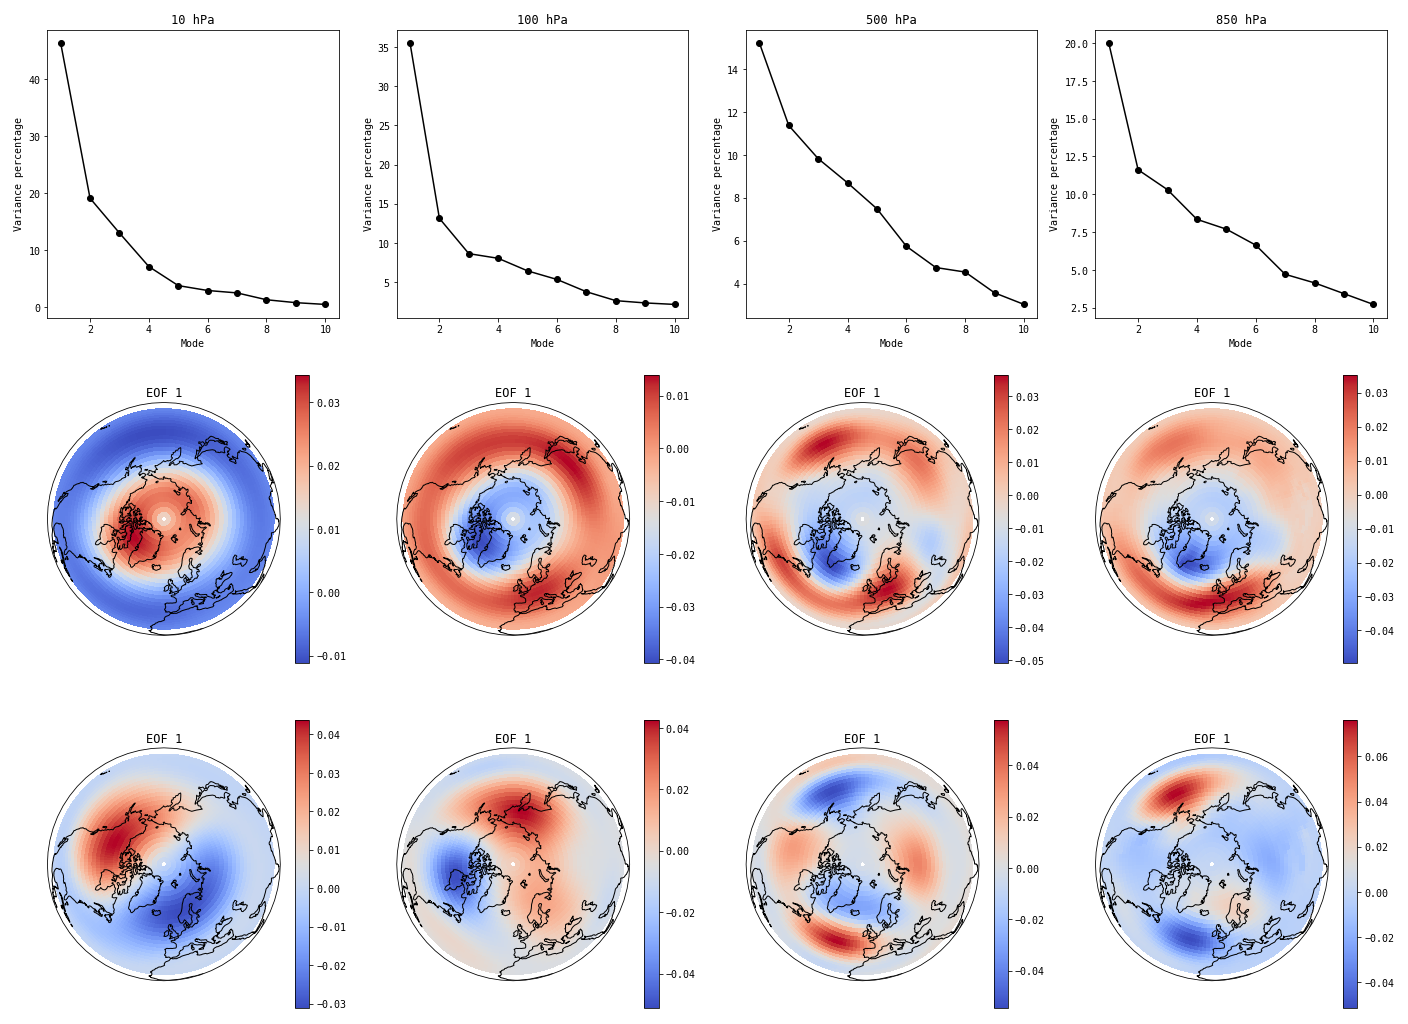

In [10]:
fig = plt.figure(figsize=(24,18))
eofs, variance_fraction = ds_eofs["eofs"], ds_eofs["variance_fraction"]
for i_lev in range(4):
    # Plot singular value spectrum
    ax = fig.add_subplot(3,4,i_lev+1)
    vf = variance_fraction.isel(level=i_lev)
    ax.plot(variance_fraction.mode, 100*variance_fraction.isel(level=i_lev), marker='o', color='black')
    ax.set_xlabel("Mode")
    ax.set_ylabel("Variance percentage")
    ax.set_title(f"{variance_fraction.level.data[i_lev]} hPa")
    # Plot EOF 1
    ax = fig.add_subplot(3,4,4+i_lev+1,projection=ccrs.Orthographic(-10,90))
    xr_utils.display_pole_field(eofs.sel(mode=1).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    # Plot EOF 2
    ax = fig.add_subplot(3,4,8+i_lev+1,projection=ccrs.Orthographic(-10,90))
    xr_utils.display_pole_field(eofs.sel(mode=2).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    

## Read database and compute features. 

In [11]:
reload(feature_stratosphere)

<module 'feature_stratosphere' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/feature_stratosphere.py'>

In [12]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

Specify any feature definitions

In [13]:
featdef = {"ds_eofs": ds_eofs, "ds_monclim": ds_monclim}

In [14]:
obs2compute = [
    "time_observable", "ubar_observable", "pc_observable", 
    "temperature_observable", "heatflux_observable",
    "qbo_observable",
]
for src in ["e5"]:
    obs_dict = dict({obsname: [] for obsname in obs2compute})
    input_dir = filedict["data"][src]["traj"]["dir"]
    input_file_list = [f for f in os.listdir(filedict["data"][src]["traj"]["dir"]) if f.endswith(".nc")]
    output_dir = filedict["data"][src]["feat_all"]["dir"]
    feat_strat.assemble_all_features(src, input_dir, input_file_list, output_dir, featdef, obs2compute=obs2compute)

Starting file number 0 out of 732
Starting file number 12 out of 732
Starting file number 24 out of 732
Starting file number 36 out of 732
Starting file number 48 out of 732
Starting file number 60 out of 732
Starting file number 72 out of 732
Starting file number 84 out of 732
Starting file number 96 out of 732
Starting file number 108 out of 732
Starting file number 120 out of 732
Starting file number 132 out of 732
Starting file number 144 out of 732
Starting file number 156 out of 732
Starting file number 168 out of 732
Starting file number 180 out of 732
Starting file number 192 out of 732
Starting file number 204 out of 732
Starting file number 216 out of 732
Starting file number 228 out of 732
Starting file number 240 out of 732
Starting file number 252 out of 732
Starting file number 264 out of 732
Starting file number 276 out of 732
Starting file number 288 out of 732
Starting file number 300 out of 732
Starting file number 312 out of 732
Starting file number 324 out of 732
St

Reload the TPT features as a dictionary. We don't yet put them in a single dataset in order to avoid dimension conflicts. 

In [15]:
feat_all = dict()
for src in ["e5"]:
    feat_all[src] = dict({
        obsname: xr.open_dataarray(join(filedict["data"][src]["feat_all"]["dir"], f"{obsname}.nc"))
        for obsname in [
            "time_observable", "ubar_observable", "pc_observable",
            "temperature_observable", "heatflux_observable", "qbo_observable"
        ]
    })

Plot some climatological envelopes

In [16]:
feat_all["e5"]["ubar_observable"].coords

Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2019-12-31
  * feature  (feature) object 'ubar_10_60' 'ubar_100_60' ... 'ubar_850_60'

In [ ]:
y = 

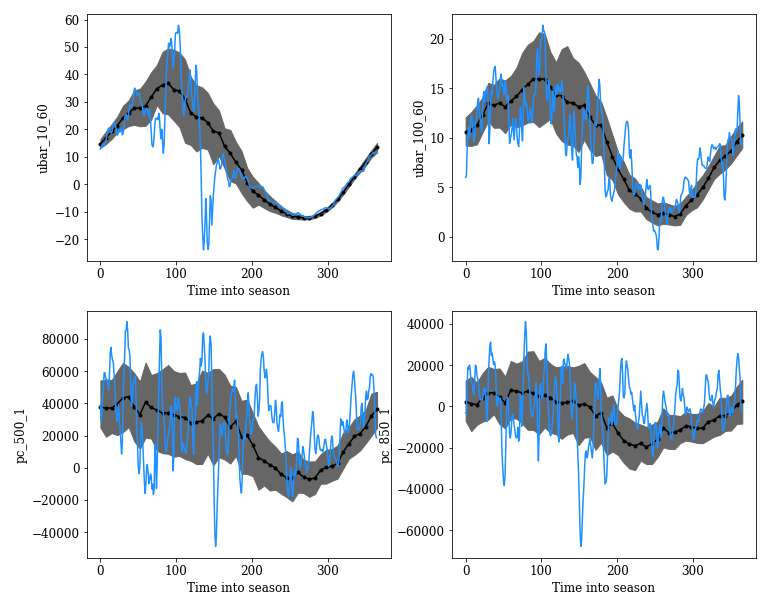

In [21]:
fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
# One observable per column
# One level per row 
groups2plot = ["ubar_observable","ubar_observable","pc_observable","pc_observable"]
obs2plot = ["ubar_10_60", "ubar_100_60", "pc_500_1", "pc_850_1"]
year2plot = 2017
cond = 1*(feat_all["e5"]["time_observable"].sel(feature="year_szn_start") == year2plot)

for i_ax in range(len(axes.flat)):
    tpt_utils.plot_field_1d(
        feat_all["e5"][groups2plot[i_ax]].sel(feature=obs2plot[i_ax]).to_numpy(), 
        np.ones(feat_all["e5"][groups2plot[i_ax]].time.size), 
        feat_all["e5"]["time_observable"].sel(feature="t_szn").to_numpy(),
        feat_name="Time into season", field_name=obs2plot[i_ax],
        fig=fig, ax=axes.flat[i_ax], nbins=50
    )
    axes.flat[i_ax].plot(
        feat_all["e5"]["time_observable"].where(cond,drop=True).sel(feature="t_szn").to_numpy(),
        feat_all["e5"][groups2plot[i_ax]].where(cond,drop=True).sel(feature=obs2plot[i_ax]).to_numpy(),
        color='dodgerblue'
    )

Plot some two-dimensional densities, at multiple time slices throughout the season.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='u_10_60', ylabel='pc_10_2'>)

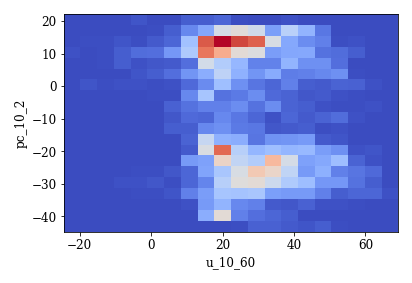

In [25]:
fig,ax = plt.subplots()
cond = 1*(
    (feat_all["e5"]["time_observable"].sel(feature="t_szn") > 0) * 
    (feat_all["e5"]["time_observable"].sel(feature="t_szn") < 100)
)
tpt_utils.plot_field_2d(
    np.ones(feat_all["e5"]["time_observable"].where(cond,drop=True).time.size), 
    np.ones(feat_all["e5"]["time_observable"].where(cond,drop=True).time.size),
    np.array([
        feat_all["e5"]["ubar_observable"].where(cond,drop=True).sel(feature="ubar_10_60").to_numpy(),
        feat_all["e5"]["qbo_observable"].where(cond,drop=True).sel(feature="ubar_10_0pm5").to_numpy(),        
    ]).T,
    feat_names = ["u_10_60", "pc_10_2"],
    fig=fig, ax=ax, shp=[20,20],
    stat_name="weightsum"
)

# Assemble features for TPT.

In [ ]:
if recombine_features_flag:
    feat_tpt = dict()
    # List the features to put into feat_tpt
    # First, the features needed to define A and B: the time, the x1 coordinate, and its running mean, min, and max
    # over some time horizon. 
    num_time_delays = 20 # Units are days
    levels = [10, 100, 500, 850]
    pcs = [1, 2, 3, 4]
    modes = np.arange(4)
    feat_tpt_list = (
        ["t_abs","t_szn","year_szn_start","t_cal",] + 
        [f"ubar_{level}_60_delay{delay}" for level in levels for delay in range(num_time_delays+1)] + 
        [f"pc_{level}_{i_pc}" for level in levels for i_pc in pcs] + 
        [f"Tcap_{level}_60to90" for level in levels] + 
        [f"vT_{level}_{mode}_runavg{delay}" for level in levels for mode in modes for delay in range(num_time_delays+1)] + 
        [f"ubar_{level}_0pm5" for level in [10, 100]]
    )
    for src in ["ra"]:
        t_abs = feat_all[src]["time_observable"].sel(feature="t_abs").to_numpy()
        t_sim = t_abs - t_abs[0]
        feat_tpt[src] = xr.DataArray(
            coords = {
                #TODO: for S2S, modify ensemble and member coordinates
                "ensemble": np.arange(1),
                "member": np.arange(1,2),
                "t_sim":  t_sim,
                "feature": feat_tpt_list,
            },
            dims = ["ensemble","member","t_sim","feature"],
        )
        print(feat_tpt[src].coords)
        # Time observables
        t_names = ["t_abs","t_szn","year_szn_start","t_cal"]
        feat_tpt[src].loc[dict(feature=t_names)] = (
            feat_all[src]["time_observable"].sel(feature=t_names)
        )
        # PC observables
        pc_names = [f"pc_{level}_{i_pc}" for level in levels for i_pc in pcs]
        feat_tpt[src].loc[dict(feature=pc_names)] = (
            feat_all[src]["pc_observable"].sel(feature=pc_names)
        )
        # Time-delayed zonal wind observables
        for i_delay in range(num_time_delays+1):
            tidx_in = np.arange(num_time_delays-i_delay,len(t_abs)-i_delay)
            tidx_out = np.arange(num_time_delays,len(t_abs))
            ubar_names_in = [f"ubar_{level}_60" for level in levels]
            ubar_names_out = [f"ubar_{level}_60_delay{i_delay}" for level in levels]
            feat_tpt[src].loc[dict(feature=ubar_names_out,t_sim=t_sim[tidx_out])] = (
                feat_all[src]["ubar_observable"].sel(feature=ubar_names_in)
                .isel(time=tidx_in).to_numpy()
            )
        # Temperature observables 
        temp_names = [f"Tcap_{level}_60to90" for level in levels]
        feat_tpt[src].loc[dict(feature=temp_names)] = (
            feat_all[src]["temperature_observable"].sel(feature=temp_names)
        )
        # Heat flux observables
        for i_delay in range(num_time_delays+1):
            vT_names_in = [f"vT_{level}_{mode}" for level in levels for mode in modes]
            vT_names_out = [f"vT_{level}_{mode}_runavg{i_delay}" for level in levels for mode in modes]
            feat_tpt[src].loc[dict(feature=vT_names_out)] = (
                feat_all[src]["heatflux_observable"].sel(feature=vT_names_in)
                .rolling(time=i_delay+1, center=False).mean().to_numpy()
            )
        # QBO observable
        qbo_names = [f"ubar_{level}_0pm5" for level in [10, 100]]
        feat_tpt[src].loc[dict(feature=qbo_names)] = (
            feat_all[src]["qbo_observable"].sel(feature=qbo_names)
        )
        # Save 
        feat_tpt[src].to_netcdf(join(filedict["data"][src]["feat_tpt"]["dir"], filedict["data"][src]["feat_tpt"]["filename"]))

# Compute the source and destination: A and B 

In [ ]:
reload(feature_stratosphere)

In [ ]:
reload(feature_template)

In [ ]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

## Estimate return time for a range of different parameters

In [ ]:
feat_strat.set_ab_boundaries(40, 150, 0.0)

In [ ]:
ab_tag = dict()
cej = dict() # Hitting times (Cotton-eye Joe)
comm_emp = dict() # Empirical committor: to B in forward time, from A in backward time
rate_emp = dict() # Empirical rate estimate 
for src in ["ra"]:
    ab_tag[src] = feat_strat.ab_test(feat_tpt[src])
    mode = "timechunks" if src == "ra" else "timesteps" # This determines the computation pattern for iterating through the dataset
    cej[src] = feat_strat.cotton_eye_joe(feat_tpt[src],ab_tag[src],mode=mode)
    comm_emp[src] = feat_strat.estimate_empirical_committor(cej[src])
    rate_emp[src] = feat_strat.estimate_rate(cej[src], comm_emp[src])
    # Save each item
    ab_tag[src].to_netcdf(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
    cej[src].to_netcdf(join(filedict["results"]["dir"], f"cej_{src}.nc"))    
    comm_emp[src].to_netcdf(join(filedict["results"]["dir"], f"comm_emp_{src}.nc"))
    rate_emp[src].to_netcdf(join(filedict["results"]["dir"], f"rate_emp_{src}.nc"))


Plot the return level vs. return time for minimum U1060. Is there some natural way to do this just using A and B definitions? 

In [ ]:
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][1]) 
)
field = feat_tpt["ra"].sel(sel,drop=True).where(cond,drop=True).sel(feature="ubar_10_60_delay0",drop=True).to_numpy().reshape(-1,1)
weights = np.ones_like(field)
year_szn_start = (
    feat_tpt["ra"].sel(sel,drop=True)
    .where(cond,drop=True).
    sel(feature="year_szn_start",drop=True).
    to_numpy().
    reshape(-1,1).astype(int)
)
bounds = np.array([[np.min(year_szn_start)-0.5], [np.max(year_szn_start)+0.5]])
shp = (np.round(bounds[1] - bounds[0])).astype(int)
ubar_yearly_stats, edges, centers = tpt_utils.project_field(  
    field, weights, year_szn_start, shp=shp, bounds=bounds
)

In [ ]:
# Function to compute return period for a list of block minima
neg_umin = -ubar_yearly_stats['min'].flatten()
order = np.argsort(neg_umin)
rank = np.argsort(order)
cdf_emp = rank / len(neg_umin)
ret_emp = 1.0/(1 - cdf_emp)

In [ ]:
fig,ax = plt.subplots()
idx, = np.where(neg_umin > 0)
ax.scatter(ret_emp[idx], neg_umin[idx], color='black', marker='.') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([1,5,10,20,30])
ax.set_yticklabels([1,5,10,20,30])
ax.set_xticks([1, 5, 10, 25, 50])
ax.set_xticklabels([1, 5, 10, 25, 50])
ax.set_xlabel("Return period (years)", font={"size": 18})
ax.set_ylabel("$-\min(\overline{u})$", font={"size": 18})

## Plot some pictures of the committor 

In [ ]:
fig,axes = plt.subplots(nrows=2, figsize=(15,10), sharex=True)
years2plot = np.arange(1984,1992)
tidx, = np.where(np.in1d(feat_tpt["ra"].sel(feature="year_szn_start").to_numpy(), years2plot))
isel = dict(ensemble=0,member=0, t_sim=tidx)
h_ubar, = xr.plot.plot(
    feat_tpt["ra"].isel(isel,drop=True).sel(feature="vT_100_1_runavg15"),
    color="black",ax=axes[0],label="$u1060$",x="t_sim"
)
handles = []
for set_code in ["A","B"]:
    color = "dodgerblue" if set_code == "A" else "red"
    starts, = np.where(np.diff(1*(ab_tag["ra"].isel(isel,drop=True).data.flatten()==feat_strat.ab_code[set_code])) == 1)
    ends, = np.where(np.diff(1*(ab_tag["ra"].isel(isel,drop=True).data.flatten()==feat_strat.ab_code[set_code])) == -1)
    if starts[0] > ends[0]: 
        ends = ends[1:]
    if starts[-1] > ends[-1]:
        starts = starts[:-1]
    for i in range(len(starts)):
        axes[0].axvspan(
            feat_tpt["ra"]["t_sim"][tidx[starts[i]]], feat_tpt["ra"]["t_sim"][tidx[ends[i]]], 
            color=color, alpha=0.5, zorder=-1
        )
    h_hittime, = xr.plot.plot(
        cej["ra"].isel(isel,drop=True).sel(state=set_code, sense="until", drop=True),
        ax=axes[1], label=r"$\tau_%s^+$"%(set_code), color=color)
    handles += [h_hittime]

axes[0].axhline(y=feat_strat.tpt_bndy["ubar_10_60_thresh"], color='black')
axes[0].legend(handles=[h_ubar], prop={"size": 18})
axes[1].legend(handles=handles, prop={"size": 18})


In [ ]:
feat = "pc_10_3" # The independent variable
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][0]+50) 
)
# Committor
qp = comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
# Next hitting time
Tb = cej["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()
tpt_utils.plot_field_1d(
    qp, np.ones(qp.size), 
    feat_tpt["ra"].sel(sel).sel(feature=feat).where(cond).data.flatten(),
    ax=axes[1], feat_name=feat, field_name="Committor to B"
)
tpt_utils.plot_field_1d(
    -Tb, qp, 
    feat_tpt["ra"].sel(sel).sel(feature=[feat]).where(cond).data.flatten(),
    ax=axes[0],
    feat_name=feat, field_name="Lead time to B",
)


In [ ]:
# Choose the two features
feat0,feat1 = "ubar_10_60_delay0","ubar_10_60_delay10"
# Select the first ensemble and member (trivial for reanalysis: there's only one realization)
sel = dict(ensemble=0,member=0) 
# Take a slice of the season, between two times
cond = (
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][0] + 50) 
)
# Call the committor qp (q-plus) and the hitting time to B Tb
qp = comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
Tb = cej["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()

fig,axes = plt.subplots(ncols=3,figsize=(15,5), sharey=True, sharex=True)
# First plot: committor
tpt_utils.plot_field_2d(
    qp, # function values
    np.ones(feat_tpt["ra"]["t_sim"].size), # weights
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True), # Feature space
    feat_names = [feat0,feat1],  # axis labels
    shp=[20,20], # shape of the 2D grid controls how pixellated the image is
    fig=fig, ax=axes[0], field_name=r"$q_B^+$" #other display parameters
)
# Second plot: hitting time (negative, so it increases towards B)
tpt_utils.plot_field_2d(
    -Tb,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[20,20], fig=fig, ax=axes[1], field_name=r"$-\tau_B^+$"
)
# Third plot: hitting time conditioned on hitting B first
tpt_utils.plot_field_2d(
    -Tb*qp,
    qp,
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[20,20], fig=fig, ax=axes[2], field_name=r"$-\eta_B^+$"
)


# Estimate the rate from ERA5. 

And include error bars. This time, we will plot return period as a function of return level.